Exospheric metals
===============

Adapted from the `p-winds` tutorial by the same name on Feb 16, 2023 by MGS.

Some extremely hot planets may be in a state of hydrodynamic escape, in which the outflow of H is so intense, that it can drag up heavier species, like C and O to the upper atmosphere of the planet. In this notebook, we will use `p-winds` to quantify the amount of C and O in the exosphere of the hot Jupiter HD 209458 b using the modules `carbon` and `oxygen` (version 1.4.1 and onwards).

As always, let's start by importing the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.units as u
import astropy.constants as c
from p_winds import tools, parker, hydrogen, helium, carbon, oxygen, lines, transit, microphysics

# Uncomment the next line if you have a MacBook with retina screen
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 9.0,6.5
pylab.rcParams['font.size'] = 18

We are going to replicate the [quickstart example for HD 209458 b](https://p-winds.readthedocs.io/en/latest/quickstart.html) and include the tidal effects. We will assume that the planet has an isothermal upper atmosphere with temperature of $9\,100$ K and a total mass loss rate of $2 \times 10^{10}$ g s$^{-1}$ based on the results from [Salz et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...586A..75S/abstract). We will also assume: 
* The atmosphere is mostly made up of H and He with number fractions $0.9$ and $0.1$, respectively
* C and O are trace elements with solar abundance based on [Asplund et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ARA%26A..47..481A/abstract). `p-winds` uses these solar values by default, but they can be set by the user if preferred.
* The H and He nuclei are fully neutral near the planet's surface (this is going to be self-consistently calculated later). In the case of C, we assume they are fully singly-ionized near the surface.

We will also need to know other parameters, namely: the stellar mass and radius, and the semi-major axis of the orbit.

In [2]:
# HAT-P-67 b planetary parameters, measured
R_pl = 2.085  # Planetary radius in Jupiter radii
M_pl = 0.34  # Planetary mass in Jupiter masses
impact_parameter = 0.04  # Transit impact parameter
a_pl = 0.065  # Orbital semi-major axis in astronomical units

# HAT-P-67 b stellar parameters
R_star = 2.546  # Stellar radius in solar radii
M_star = 1.642  # Stellar mass in solar masses

In [3]:
m_dot = M_pl*u.Mjup/(13.6*u.Gyr)
m_dot = m_dot.to(u.g/u.s)
m_dot

<Quantity 1.50369847e+12 g / s>

In [4]:
# A few assumptions about the planet's atmosphere
m_dot = m_dot.value * 30  # Total atmospheric escape rate in g / s
T_0 = 9_100  # Wind temperature in K
h_fraction = 0.90  # H number fraction
he_fraction = 1 - h_fraction  # He number fraction
he_h_fraction = he_fraction / h_fraction
mean_f_ion = 0.0  # Mean ionization fraction (will be self-consistently calculated later)
mu_0 = (1 + 4 * he_h_fraction) / (1 + he_h_fraction + mean_f_ion)  
# mu_0 is the constant mean molecular weight (assumed for now, will be updated later)

In [5]:
# The trace abundances of C and O
c_abundance = 8.43  # Asplund et al. 2009
c_fraction = 10 ** (c_abundance - 12.00)
o_abundance = 8.69  # Asplund et al. 2009
o_fraction = 10 ** (o_abundance - 12.00)

Next, we retrieve the high-energy spectrum of the host star with fluxes at the planet. For this example, we use the solar spectrum for convenience.

In [6]:
from gollum.phoenix import PHOENIXSpectrum

In [7]:
stellar_spec = PHOENIXSpectrum(teff=6400, logg=3.5, wl_lo=1, wl_hi=10_000)
flux_density = stellar_spec.flux.to(u.erg/u.s/(u.cm**2)/u.Angstrom)/(np.pi*u.steradian) # convert to erg/cm^2/s/A/steradian

omega = np.pi*(R_star*u.Rsun)**2/(a_pl*u.AU)**2
omega = omega.to(u.steradian, equivalencies=u.dimensionless_angles())
flux_at_planet_surface = flux_density * omega

spectrum_F ={'wavelength':stellar_spec.wavelength.value,
           'flux_lambda':flux_at_planet_surface.value,
           'wavelength_unit':u.Angstrom,
           'flux_unit':flux_at_planet_surface.unit}

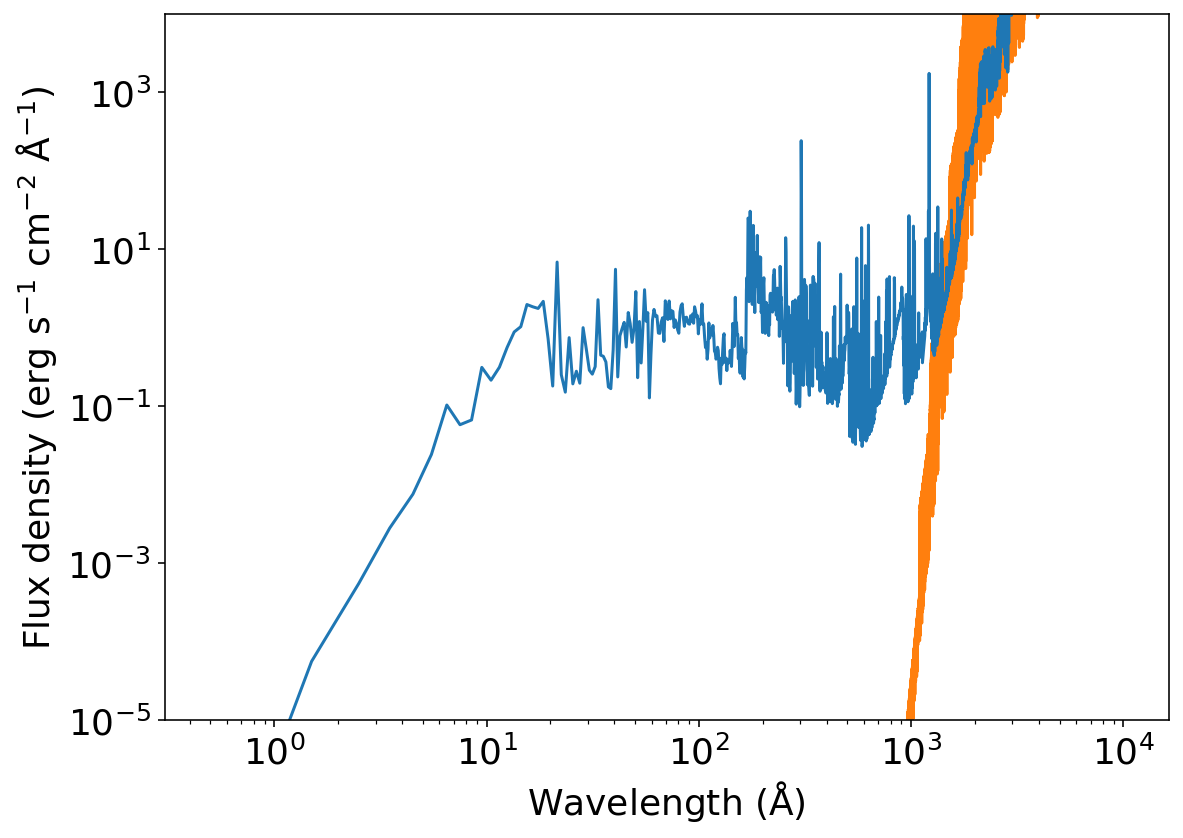

In [8]:
units = {'wavelength': u.angstrom, 'flux': u.erg / u.s / u.cm ** 2 / u.angstrom}
spectrum = tools.make_spectrum_from_file('/Users/mag3842/GitHub/p-winds/data/solar_spectrum_scaled_lambda.dat',
                                    units)
plt.loglog(spectrum['wavelength'], spectrum['flux_lambda'])
plt.loglog(spectrum_F['wavelength'], spectrum_F['flux_lambda'], zorder=-1)
plt.ylim(1E-5, 1E4)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel(r'Flux density (erg s$^{-1}$ cm$^{-2}$ ${\rm \AA}^{-1}$)')
plt.show()

Now we can calculate the distribution of ionized/neutral hydrogen and the structure of the upper atmosphere.

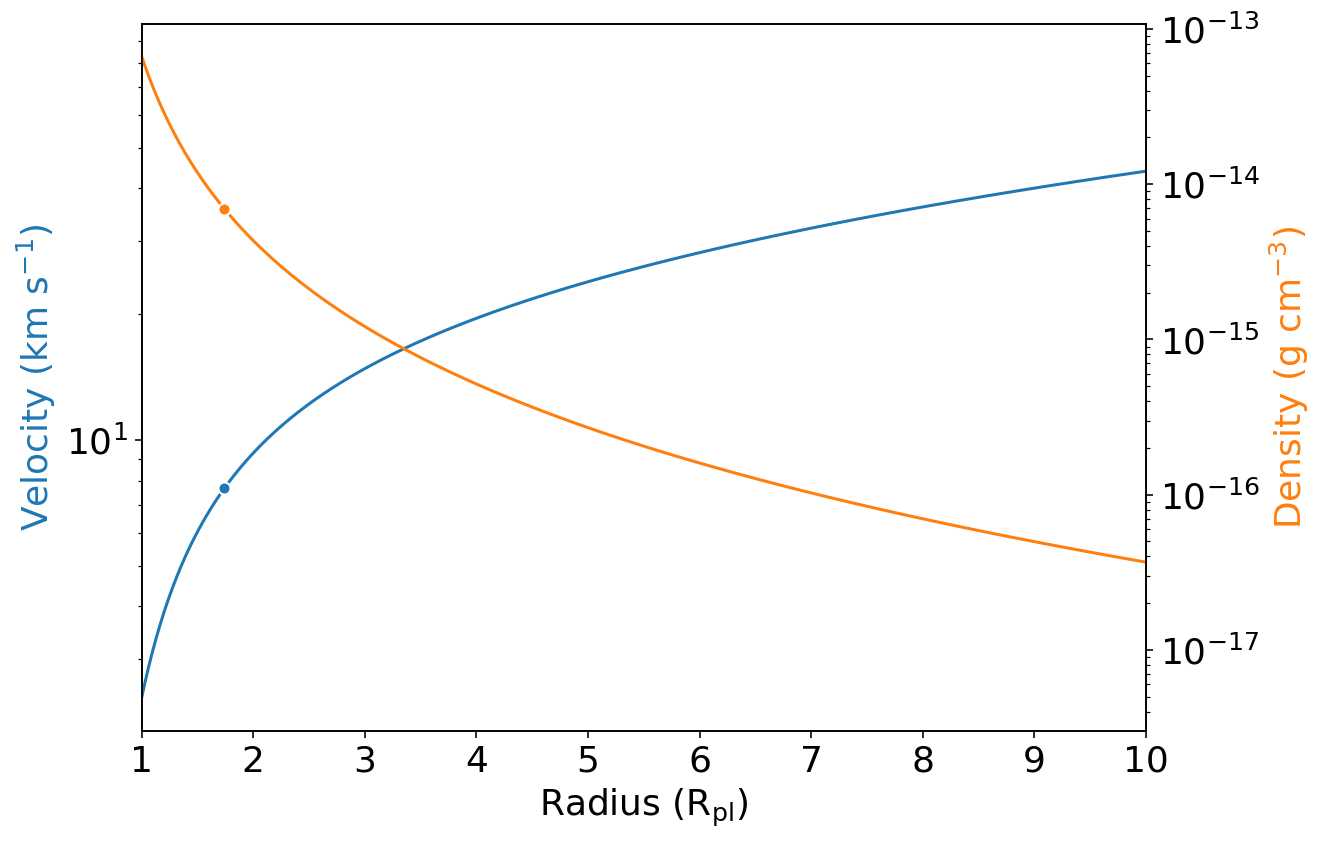

In [9]:
initial_f_ion = 0.0
r = np.logspace(0, np.log10(20), 100)  # Radial distance profile in unit of planetary radii

f_r, mu_bar = hydrogen.ion_fraction(r, R_pl, T_0, h_fraction, 
                            m_dot, M_pl, mu_0, star_mass=M_star,
                            semimajor_axis=a_pl,
                            spectrum_at_planet=spectrum, exact_phi=True,
                            initial_f_ion=initial_f_ion, relax_solution=True,
                            return_mu=True)

f_ion = f_r
f_neutral = 1 - f_r

vs = parker.sound_speed(T_0, mu_bar)  # Speed of sound (km/s, assumed to be constant)
rs = parker.radius_sonic_point_tidal(M_pl, vs, M_star, a_pl)  # Radius at the sonic point (jupiterRad)
rhos = parker.density_sonic_point(m_dot, rs, vs)  # Density at the sonic point (g/cm^3)

r_array = r * R_pl / rs
v_array, rho_array = parker.structure_tidal(r_array, vs, rs, M_pl, M_star, a_pl)

# Convenience arrays for the plots
r_plot = r_array * rs / R_pl
v_plot = v_array * vs
rho_plot = rho_array * rhos

# Finally plot the structure of the upper atmosphere
# The circles mark the velocity and density at the sonic point
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r_plot, v_plot, color='C0')
ax1.plot(rs / R_pl, vs, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r_plot, rho_plot, color='C1')
ax2.plot(rs / R_pl, rhos, marker='o', markeredgecolor='w', color='C1')
ax1.set_xlabel(r'Radius (R$_{\rm pl}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 10)
plt.show()

We will also need the neutral and ion fractions of helium.

In [10]:
# Calculate the helium ion fraction
f_he_plus = helium.ion_fraction(
    r, v_array, rho_array, f_ion,
    R_pl, T_0, h_fraction, vs, rs, rhos, spectrum,
    initial_f_he_ion=0.0, relax_solution=True)

# Hydrogen atom mass
m_h = c.m_p.to(u.g).value

# Number density of helium nuclei 
he_fraction = 1 - h_fraction
n_he = (rho_array * rhos * he_fraction / (1 + 4 * he_fraction) / m_h)
n_he_ion = f_he_plus * n_he

With all this setup done, we will proceed to calculate the number densities of neutral, singly-ionized and doubly-ionized C. We will assume that the C nuclei are all singly-ionized near the surface (so `initial_f_c_ion` is `[1.0, 0.0]`).

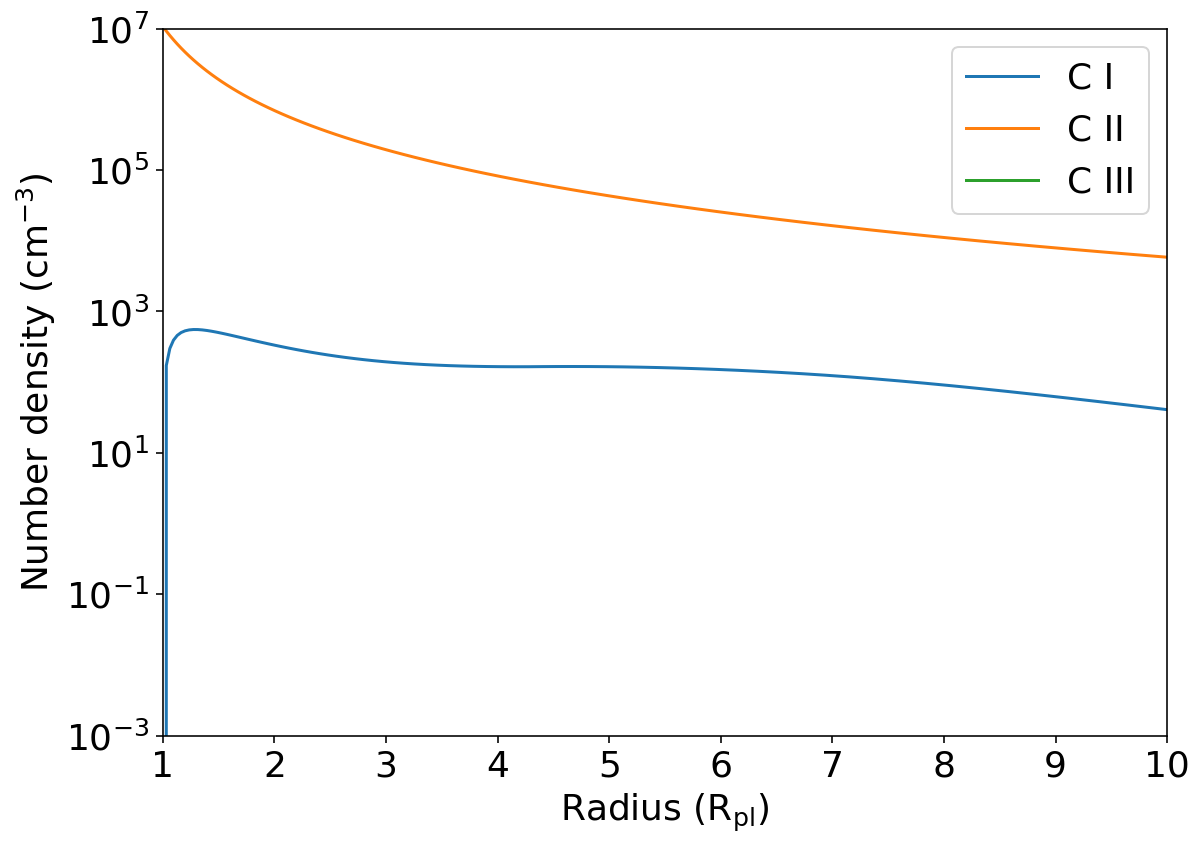

In [13]:
f_c_ii, f_c_iii = carbon.ion_fraction(radius_profile=r,
                                      velocity=v_array,
                                      density=rho_array,
                                      hydrogen_ion_fraction=f_ion,
                                      helium_ion_fraction=f_he_plus,
                                      planet_radius=R_pl,
                                      temperature=T_0,
                                      h_fraction=h_fraction,
                                      c_fraction=c_fraction,
                                      speed_sonic_point=vs,
                                      radius_sonic_point=rs,
                                      density_sonic_point=rhos,
                                      spectrum_at_planet=spectrum,
                                      initial_f_c_ion=np.array([1.0, 0.0]),
                                      relax_solution=True,method='Radau')

# Number density of carbon nuclei 
n_c = (rho_array * rhos * c_fraction / (1 + 6 * c_fraction) / m_h)

n_c_i = (1 - f_c_ii - f_c_iii) * n_c
n_c_ii = f_c_ii * n_c
n_c_iii = f_c_iii * n_c

plt.semilogy(r, n_c_i, color='C0', label='C I')
plt.semilogy(r, n_c_ii, color='C1', label='C II')
plt.semilogy(r, n_c_iii, color='C2', label='C III')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-3, 1E7)
plt.legend()
plt.show()

In the plot above we see that most of the C nuclei in the upper atmosphere of HD 209458 b are singly-ionized, with only a small fraction of them in neutral state by a factor of 3 orders of magnitude. Furthermore, doubly-ionized C are not present.

Next, we do the same exercise for oxygen. We will assume that all O nuclei are neutral near the surface at first.

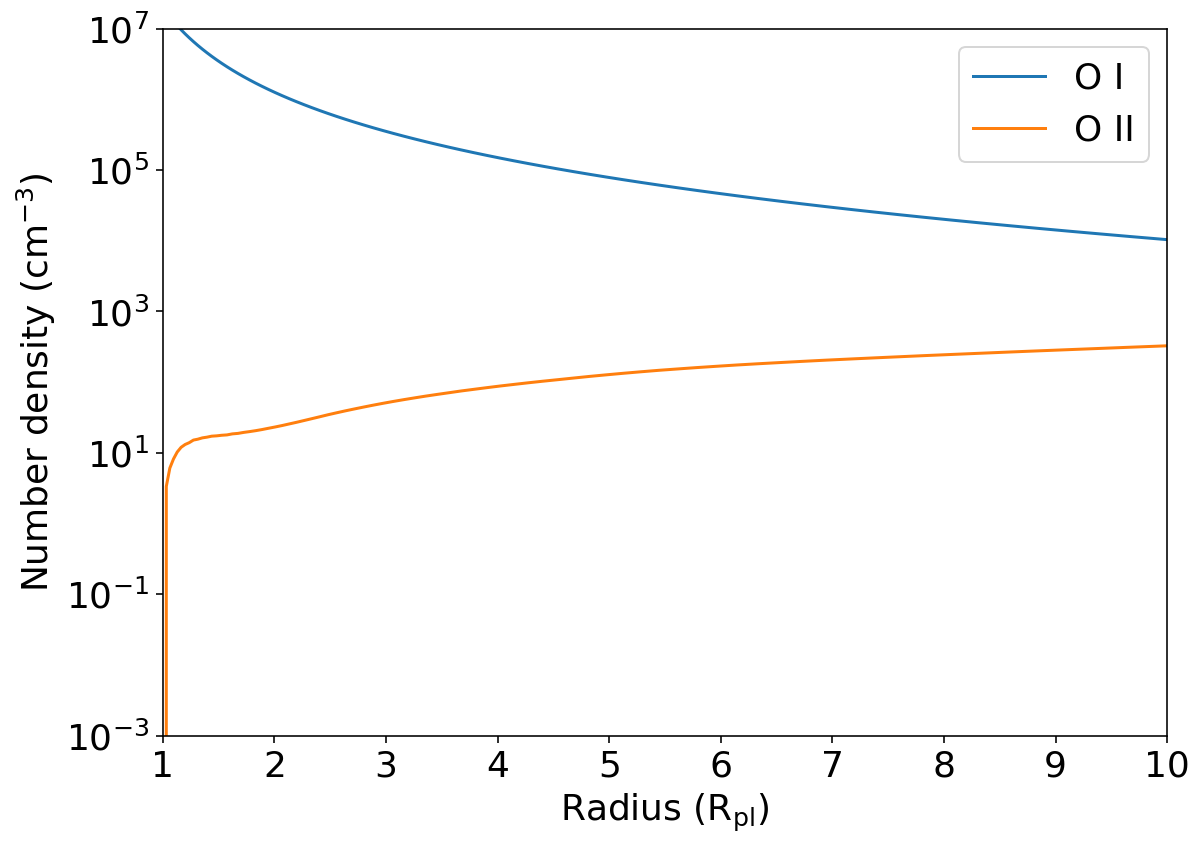

In [17]:
f_o_ii = oxygen.ion_fraction(radius_profile=r,
                             velocity=v_array,
                             density=rho_array,
                             hydrogen_ion_fraction=f_ion,
                             helium_ion_fraction=f_he_plus,
                             planet_radius=R_pl,
                             temperature=T_0,
                             h_fraction=h_fraction,
                             o_fraction=o_fraction,
                             speed_sonic_point=vs,
                             radius_sonic_point=rs,
                             density_sonic_point=rhos,
                             spectrum_at_planet=spectrum,
                             initial_f_o_ion=0.0,
                             relax_solution=True, method='Radau')

# Number density of oxygen nuclei 
n_o = (rho_array * rhos * o_fraction / (1 + 8 * o_fraction) / m_h)

n_o_i = (1 - f_o_ii) * n_o
n_o_ii = f_o_ii * n_o

plt.semilogy(r, n_o_i, color='C0', label='O I')
plt.semilogy(r, n_o_ii, color='C1', label='O II')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-3, 1E7)
plt.legend()
plt.show()

And there we see that most of the oxygen nuclei are singly-ionized, except in the innermost upper atmosphere layers, where neutral oxygen dominates.

For the next part of this tutorial, we will estimate the in-transit absorption profiles for the relevant wavelengths in real observations. These exospheric carbon and oxygen lines are located in the ultraviolet, which are accessible only with the *Hubble Space Telescope*.

The tricky part of the C II triplet is that the line at 133.4 nm arises from the ground state, and the other two at 133.5 nm are a doublet arising from the first excited state. The number density of C II we calculated above assumes that all nuclei are in the ground state, and we need to estimate how many of them are in the excited state as well.

There are a few ways of calculating the population of C II nuclei. I used the [`ChiantiPy` code](https://github.com/chianti-atomic/ChiantiPy/), and estimated that, for the exosphere of HD 209458 b (temperature 9100 K and density of electrons $\sim 6 \times 10^6$ cm$^{-3}$), we have roughly 33% of C II ions in the ground state, and 66% in the excited state.

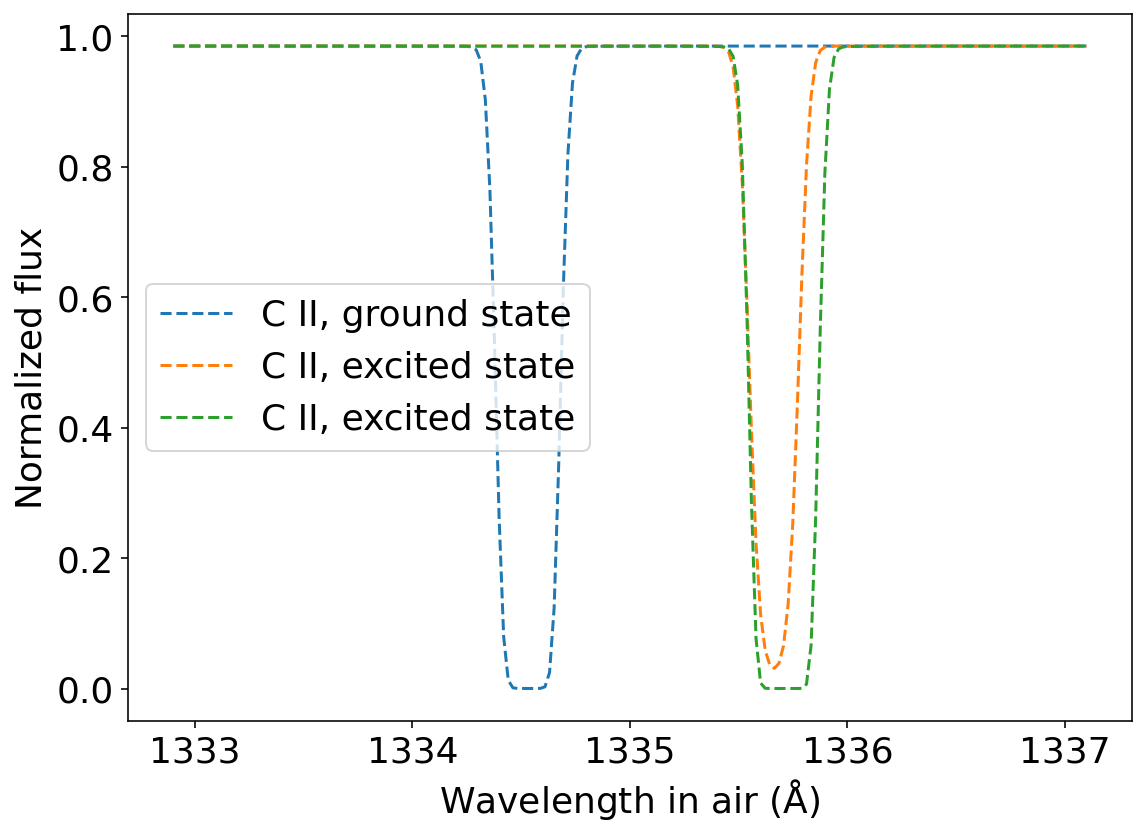

In [18]:
# Set up the ray tracing. We will use a coarse 100-px grid size,
# but we use supersampling to avoid hard pixel edges.
# We convert everything to SI units because they make our lives
# much easier.
R_pl_physical = R_pl * 71492000  # Planet radius in m
r_SI = r * R_pl_physical  # Array of altitudes in m
v_SI = v_array * vs * 1000  # Velocity of the outflow in m / s
n_c_ii_SI = n_c_ii * 1E6  # Volumetric densities in 1 / m ** 3
planet_to_star_ratio = 0.12086

flux_map, t_depth, r_from_planet = transit.draw_transit(
    planet_to_star_ratio, 
    planet_physical_radius=R_pl_physical, 
    impact_parameter=impact_parameter, 
    phase=0.0,
    supersampling=10,
    grid_size=100)

# Retrieve the properties of the C II lines; they were hard-coded
# using the tabulated values of the NIST database
# wX = central wavelength, fX = oscillator strength, a_ij = Einstein coefficient
w0, w1, w2, f0, f1, f2, a_ij_0, a_ij_1, a_ij_2 = lines.c_ii_properties()

m_C = 6 * 1.67262192369e-27  # Carbon atomic mass in kg
wl = np.linspace(1332.9, 1337.1, 200) * 1E-10  # Wavelengths in Angstrom

method = 'average'

spectrum_0 = transit.radiative_transfer_2d(flux_map, r_from_planet,  # Ground state
                                        r_SI, n_c_ii_SI * 0.33, v_SI, w0, f0, a_ij_0,
                                        wl, T_0, m_C, wind_broadening_method=method) 
spectrum_1 = transit.radiative_transfer_2d(flux_map, r_from_planet,  # Excited state
                                        r_SI, n_c_ii_SI * 0.66, v_SI, w1, f1, a_ij_1,
                                        wl, T_0, m_C, wind_broadening_method=method)
spectrum_2 = transit.radiative_transfer_2d(flux_map, r_from_planet,  # Excited state
                                        r_SI, n_c_ii_SI * 0.66, v_SI, w2, f2, a_ij_2,
                                        wl, T_0, m_C, wind_broadening_method=method)

plt.plot(wl * 1E10, spectrum_0, ls='--', label='C II, ground state')
plt.plot(wl * 1E10, spectrum_1, ls='--', label='C II, excited state')
plt.plot(wl * 1E10, spectrum_2, ls='--', label='C II, excited state')
plt.legend()
plt.xlabel(r'Wavelength in air (${\rm \AA}$)')
plt.ylabel('Normalized flux')
plt.show()

And now for the oxygen lines. Similarly, the first line is a resonant line, and the other two are doubles arising from two different excited states. 

From `ChiantiPy`, the ratios for the ground state, the first and second excited states are 0.85, 0.10 and 0.05.

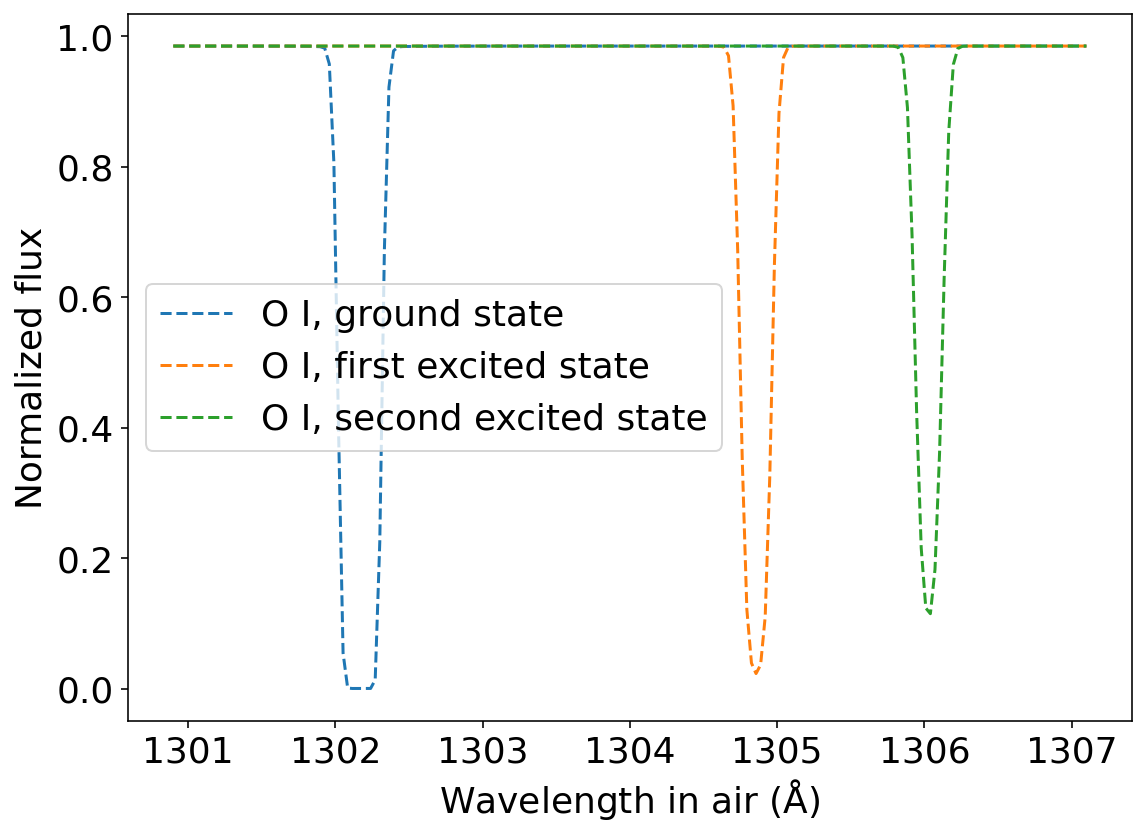

In [19]:
n_o_i_SI = n_o_i * 1E6  # Volumetric densities in 1 / m ** 3

# Retrieve the properties of the O I triplet; they were hard-coded
# using the tabulated values of the NIST database
# wX = central wavelength, fX = oscillator strength, a_ij = Einstein coefficient
w0, w1, w2, f0, f1, f2, a_ij_0, a_ij_1, a_ij_2 = lines.o_i_properties()

m_O = 8 * 1.67262192369e-27  # Oxygen atomic mass in kg
wl = np.linspace(1300.9, 1307.1, 200) * 1E-10  # Wavelengths in Angstrom

method = 'average'

spectrum_0 = transit.radiative_transfer_2d(flux_map, r_from_planet,  # Ground state
                                        r_SI, n_o_i_SI * 0.85, v_SI, w0, f0, a_ij_0,
                                        wl, T_0, m_O, wind_broadening_method=method)
spectrum_1 = transit.radiative_transfer_2d(flux_map, r_from_planet,  # First excited state
                                        r_SI, n_o_i_SI * 0.10, v_SI, w1, f1, a_ij_1,
                                        wl, T_0, m_O, wind_broadening_method=method)
spectrum_2 = transit.radiative_transfer_2d(flux_map, r_from_planet,  # Second excited state
                                        r_SI, n_o_i_SI * 0.05, v_SI, w2, f2, a_ij_2,
                                        wl, T_0, m_O, wind_broadening_method=method)

plt.plot(wl * 1E10, spectrum_0, ls='--', label='O I, ground state')
plt.plot(wl * 1E10, spectrum_1, ls='--', label='O I, first excited state')
plt.plot(wl * 1E10, spectrum_2, ls='--', label='O I, second excited state')
plt.legend()
plt.xlabel(r'Wavelength in air (${\rm \AA}$)')
plt.ylabel('Normalized flux')
plt.show()

What we can conclude from this exercise is that, if we assume a Parker-wind like escape for HD 209458 b, solar abundances of C and O, and a solar-like high-energy spectrum for the host star, then the excess in-transit signature of neutral O will be about 0.5% in the core of the strongest O I line in the UV. For C II, a much promising signature stronger than 7.5% will be present in the strongest line of the transmission spectrum.